Import useful packages for time series analysis below:

In [100]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model, metrics
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

Read and visualize data file into dataframe:

In [101]:
df = pd.read_csv('../data/staff_data_model.csv')
df

,Year,Volunteer,Paid,Total
0,15/16,52,34,86
1,16/17,51,30,81
2,17/18,48,30,78
3,18/19,75,28,103
4,19/20,69,24,93
5,20/21,69,22,91
6,21/22,64,28,92
7,22/23,73,26,99
8,23/24,67,30,97


Text(0.5, 1.0, 'Academic Yearly staff count over 2015-2024')

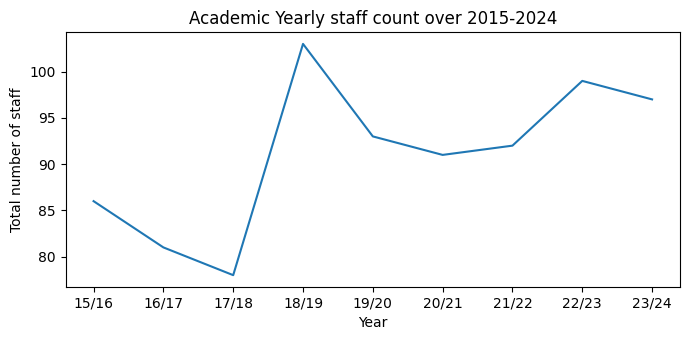

In [102]:
plt.plot(df["Year"], df["Total"])
plt.xlabel("Year")
plt.ylabel("Total number of staff")
plt.title("Academic Yearly staff count over 2015-2024")

## ARIMA Model to forecast staff count for the next 3 years

Autocorrelation plot to determine ARIMA model parameters:

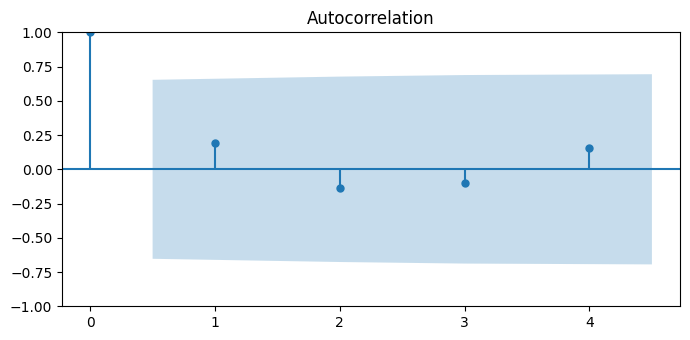

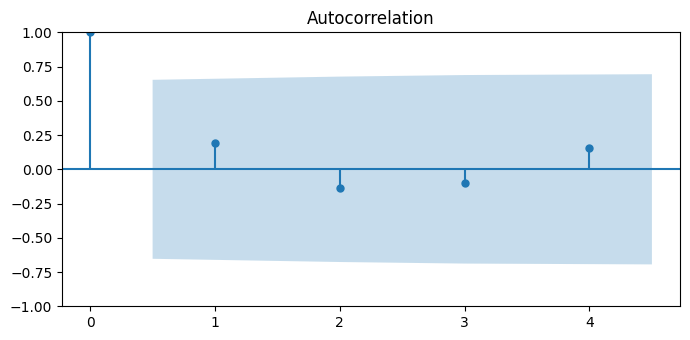

In [103]:
plot_acf(df["Total"])

Autocorrelations seem very low, and ARIMA model may not be appropriate, but we try fitting one below:

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                    9
Model:                 ARIMA(4, 1, 0)   Log Likelihood                 -28.031
Date:                Wed, 06 Mar 2024   AIC                             66.063
Time:                        18:51:40   BIC                             66.460
Sample:                             0   HQIC                            63.384
                                  - 9                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5333      6.188     -0.086      0.931     -12.662      11.595
ar.L2         -0.4474      5.244     -0.085      0.932     -10.726       9.831
ar.L3         -0.3078      5.309     -0.058      0.9

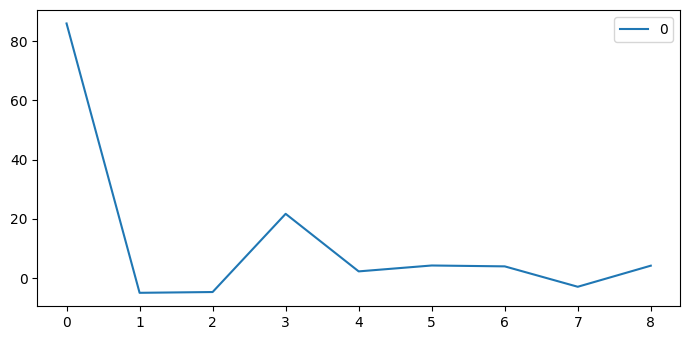

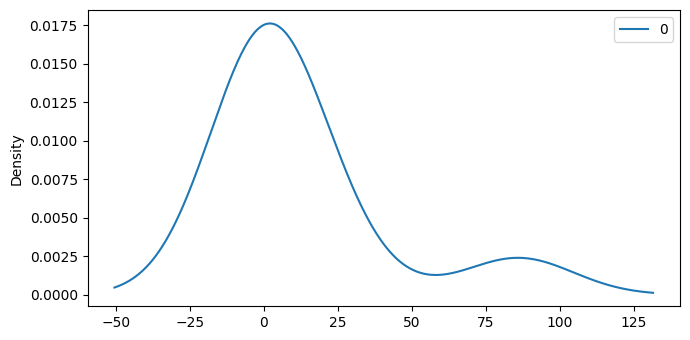

               0
count   9.000000
mean   12.176114
std    28.818476
min    -4.997042
25%    -2.954805
50%     3.936672
75%     4.232623
max    86.000000


In [104]:
model = ARIMA(df["Total"], order=(4,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

From the residual plot, there does not seem to be any trend information not captured by the model, as the mean is relevantly stable
The density plot shows that the errors are roughly Gaussian and roughly centers around 0, though the right tail may be a bit thicker and it is slightly biased as the mean is not 0

Split the data into training and testing

In [173]:
X = df["Total"]
init_year = 2015 # start of the time series
# 2/3 of the data for training, 1/3 of the data for testing
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
# Define number of periods to predict
pred_pd = 3
print("training data: \n", train)
print("testing data: \n", test)

training data: 
 0     86
1     81
2     78
3    103
4     93
Name: Total, dtype: int64
testing data: 
 5    91
6    92
7    99
8    97
Name: Total, dtype: int64


Train the model

In [174]:
import warnings
warnings.warn("deprecated", DeprecationWarning)
warnings.simplefilter("ignore")

In [175]:
history = [x for x in train]

# Define reuseable walk-forward validation function to calculate validity of model
def arima_model(p, d, q, training, testing, pred_periods, test):
  forecasts = list() # keeps track of all the predicted points
  history = list(training.copy()) # captures walk-forward training data
  testdata = list(testing.copy()) # keeps a list copy for testing data to avoid dataframe row name mismatch
  error = 0 # sum of the errors
  for t in range(len(testdata)):
    obs = testdata[t]
    model = ARIMA(history, order=(p,d,q)) # update the training set to include the latest predicted value
    model_fit = model.fit()
    yhat = model_fit.forecast() # predicted data point
    forecasts.append(float(yhat))
    history.append(float(yhat))
    error += (yhat - obs) **2
  rmse = math.sqrt(error/len(testdata))
  if test: # test is the parameter to indicate whether this function is used to predict / test
    return round(rmse, 2), forecasts
  else:
    return round(rmse, 2), forecasts[:pred_periods]
print("Training RMSE: ", arima_model(4, 1, 0, train, train, pred_pd, 1)[0])

Training RMSE:  9.68


Parameter tuning for ARIMA model

In [176]:
def find_arima_params(prange, drange, qrange, train, test, pred_period):
    params = [0,0,0]
    min_rmse = float('inf')
    for p in range(1,prange):
        for q in range(1,qrange):
            for d in range(1, drange):
                error = arima_model(p,d,q,train,test, pred_period, 0)[0]
                # print(error, min_rmse)
                if min_rmse >= error:
                    min_rmse = error
                    params = [p,d,q]
    return params
arima_params = find_arima_params(5, 3, 2, train, test, pred_pd)
print(arima_params)

[1, 1, 1]


Test + Validation

In [178]:
test_forecast = arima_model(arima_params[0], arima_params[1], arima_params[2], train, test, pred_pd, 1)
print("Testing RMSE: ", test_forecast[0])

Testing RMSE:  7.08


Forecast for the next 3 years

In [179]:
forecasts = arima_model(arima_params[0], arima_params[1], arima_params[2], X, X, pred_pd, 0)[1]
print("Forecasts: ", forecasts)

Forecasts:  [95.46798307839227, 95.30906868333983, 95.27063097985092]


Plot actual vs prediction

           0
5  89.442899
6  88.594875
7  88.406927
8  88.378200
            0
9   95.467983
10  95.309069
11  95.270631


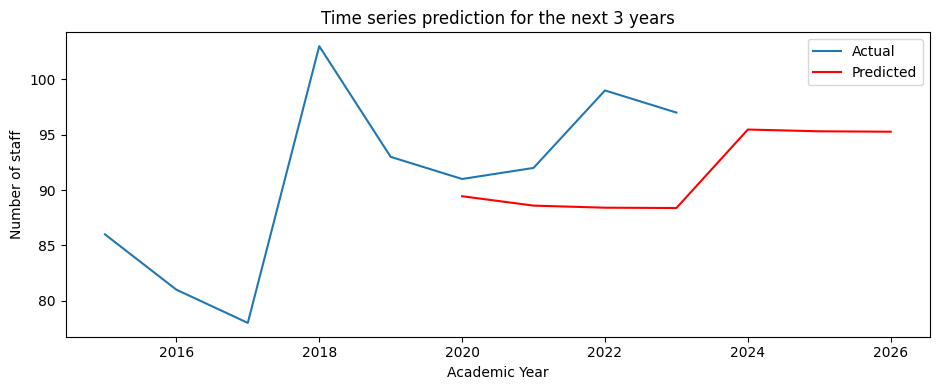

In [181]:
def plot_time_series_model(data, test, test_forecast, forecasts, init_year):
    df_test_forecast = pd.DataFrame(test_forecast[1], index=test.index)
    print(df_test_forecast)
    df_forecast = pd.DataFrame(forecasts, index=range(test.index[-1]+1, test.index[-1]+len(forecasts)+1))
    print(df_forecast)
    years = range(init_year, init_year + len(data) + pred_pd)
    plt.figure(figsize=(9.5,4))
    plt.xlabel('Academic Year', fontsize=10)
    plt.ylabel('Number of staff', fontsize=10)
    plt.title("Time series prediction for the next 3 years")
    plt.plot(years[:len(data)], data, label="Actual")
    df_pred = df_test_forecast.append(df_forecast)
    plt.plot(years[len(years) - len(forecasts) - len(test):], df_pred, color='red', label="Predicted")
    plt.legend(["Actual", "Predicted"])
    plt.show()
plot_time_series_model(X, test, test_forecast, forecasts, init_year)

It seems that due to the low autocorrelation of staff count, it is not very effective to predict staff count only based on itself through ARIMA. So we add more variables to see if we can have a better prediction

## Incorporate more variables into the time series analysis
Redo dataset construction

In [195]:
df_var = pd.read_csv('../data/Call Volume.csv')
df_var


,Academic year beginning in Fall of:,Total UG enrollment,Total Enrollment,Total Employees,Enrollment + Employees,Calls (from academic year rpt),Calls / UG Enrollment,Calls / Total Enrollment,Calls/Total Enrollment + Employees
0,2010,3443,5878,NaN,NaN,800,0.232356,0.136101,NaN
1,2011,3667,6222,NaN,NaN,856,0.233433,0.137576,NaN
2,2012,3775,6478,NaN,NaN,771,0.204238,0.119018,NaN
3,2013,3885,6629,NaN,NaN,590,0.151866,0.089003,NaN
4,2014,3845,6621,NaN,NaN,624,0.162289,0.094246,NaN
5,2015,3839,6719,NaN,NaN,637,0.165929,0.094806,NaN
6,2016,3839,6855,3519.0,10374.0,640,0.166710,0.093363,0.061693
7,2017,3933,7022,3723.0,10745.0,583,0.148233,0.083025,0.054258
8,2018,3927,7080,3848.0,10928.0,650,0.165521,0.091808,0.059480
9,2019,3942,7108,3803.0,10911.0,541,0.137240,0.076111,0.049583


Clean data to get rid of NA values

In [196]:
init_year = 2016
df_var = df_var[["Academic year beginning in Fall of:", "Total UG enrollment", "Total Enrollment", "Total Employees", "Calls (from academic year rpt)"]]
df_var = df_var[5:]
df_var = df_var[:-1]
df_var["Merge"] = range(len(df_var))
df_var = df_var.dropna()
df_var

,Academic year beginning in Fall of:,Total UG enrollment,Total Enrollment,Total Employees,Calls (from academic year rpt),Merge
6,2016,3839,6855,3519.0,640,1
7,2017,3933,7022,3723.0,583,2
8,2018,3927,7080,3848.0,650,3
9,2019,3942,7108,3803.0,541,4
10,2020,4013,7257,3842.0,248,5
11,2021,4202,7819,3775.0,738,6
12,2022,4447,8272,4078.0,913,7
13,2023,4528,8225,4371.0,954,8


In [197]:
df["Merge"] = range(len(df))
df

,Year,Volunteer,Paid,Total,Merge
0,15/16,52,34,86,0
1,16/17,51,30,81,1
2,17/18,48,30,78,2
3,18/19,75,28,103,3
4,19/20,69,24,93,4
5,20/21,69,22,91,5
6,21/22,64,28,92,6
7,22/23,73,26,99,7
8,23/24,67,30,97,8


In [198]:
merged_df = pd.merge(df, df_var, on='Merge')
merged_df = merged_df[["Merge", "Volunteer", "Paid", "Total", "Total UG enrollment", "Total Enrollment", "Total Employees", "Calls (from academic year rpt)"]]
merged_df

,Merge,Volunteer,Paid,Total,Total UG enrollment,Total Enrollment,Total Employees,Calls (from academic year rpt)
0,1,51,30,81,3839,6855,3519.0,640
1,2,48,30,78,3933,7022,3723.0,583
2,3,75,28,103,3927,7080,3848.0,650
3,4,69,24,93,3942,7108,3803.0,541
4,5,69,22,91,4013,7257,3842.0,248
5,6,64,28,92,4202,7819,3775.0,738
6,7,73,26,99,4447,8272,4078.0,913
7,8,67,30,97,4528,8225,4371.0,954


In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

Plot and visualize the variables over time separately

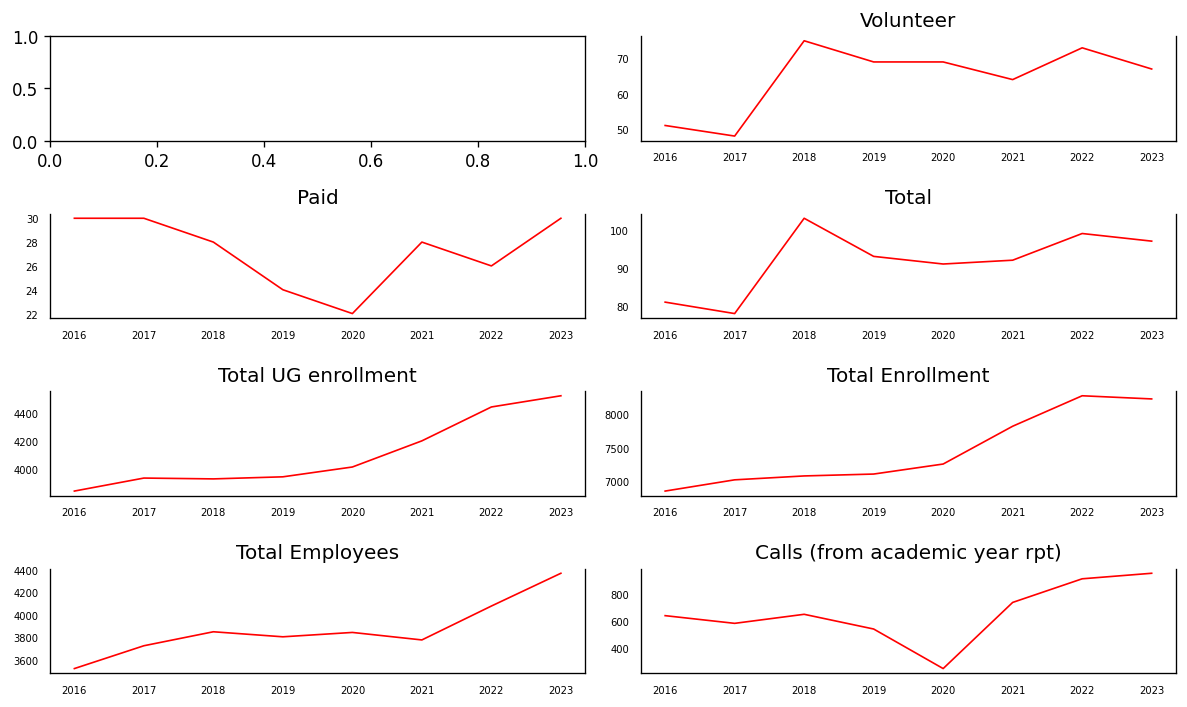

In [203]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
#print(merged_df.shape[1])
for i, ax in enumerate(axes.flatten()):
    #print(i)
    if 0 < i < merged_df.shape[1]:
        data = merged_df[merged_df.columns[i]]
        years = [x for x in range(init_year, init_year + len(data))]
        ax.plot(years, data, color='red', linewidth=1)
        # Decorations
        ax.set_title(merged_df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)

plt.tight_layout()

Construct training and testing datasets

In [201]:
size = int(0.66*len(merged_df))
df_train = merged_df.iloc[:size]  # Select the first 'size' rows
df_test = merged_df.iloc[size:]
df_train
df_test

,Merge,Volunteer,Paid,Total,Total UG enrollment,Total Enrollment,Total Employees,Calls (from academic year rpt)
5,6,64,28,92,4202,7819,3775.0,738
6,7,73,26,99,4447,8272,4078.0,913
7,8,67,30,97,4528,8225,4371.0,954


## SARIMAX model

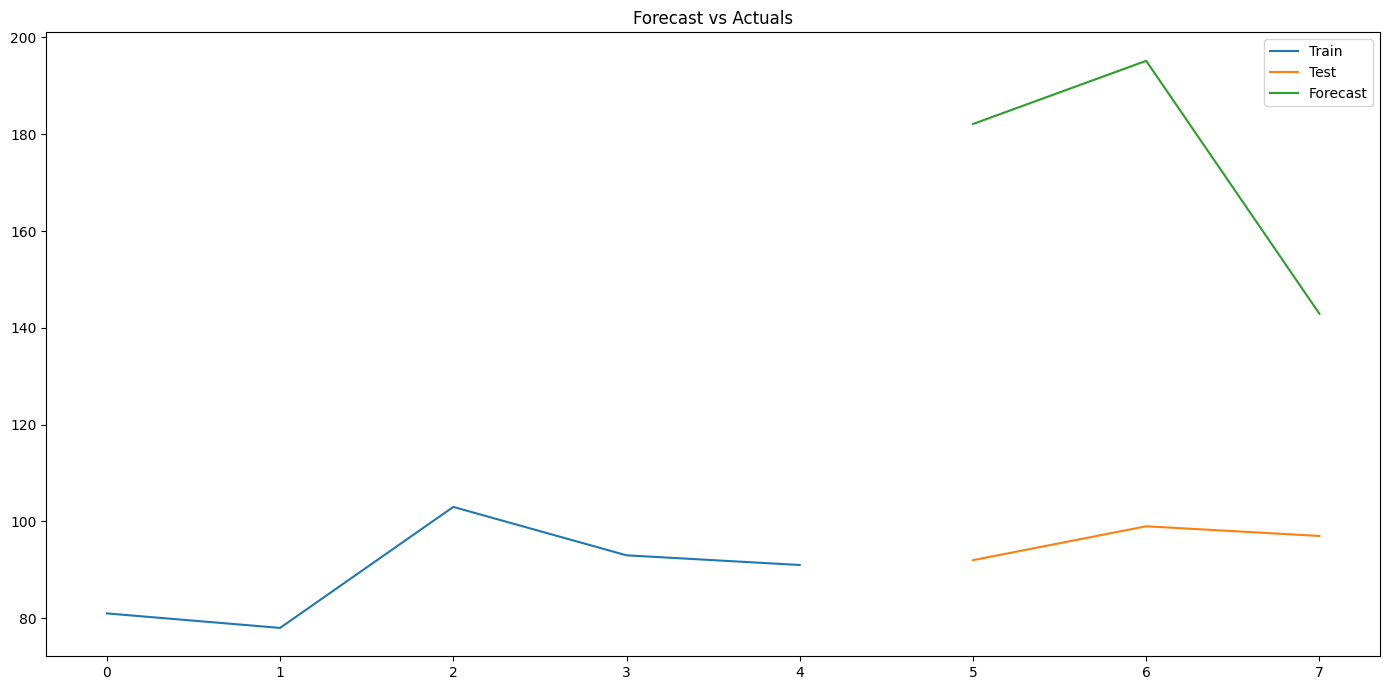

In [205]:
# merged_df.to_csv('../data/temp.csv')
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(df_train['Total'], order=(2, 0, 1), exog=df_train[['Total UG enrollment', 'Total Enrollment', 'Total Employees', 'Calls (from academic year rpt)']])
result = sarimax_model.fit()


forecast = result.get_forecast(steps=3, exog=df_test[['Total UG enrollment', 'Total Enrollment', 'Total Employees', 'Calls (from academic year rpt)']])
forecast

forecast_mean = forecast.predicted_mean

# Get confidence intervals of predictions
forecast_ci = forecast.conf_int()

# Plot the data along with the forecast and the confidence interval
plt.figure(figsize=(14, 7))
plt.plot(df_train.index, df_train['Total'], label='Train')
plt.plot(df_test.index, df_test['Total'], label='Test')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast')
plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

## VAR model
https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/

Construct the model

In [206]:
model = sm.tsa.VAR(df_train)
# Autoregressive model of order p=2, due to the limited training samples p can only be 1 or 2
# for reusability, input different order p as deemed appropriate
results = model.fit(2) 
lag_order = results.k_ar
# Forecasting
def var_pred(train, model, pred_pd):
    forecast = model.forecast(train.values, steps=pred_pd)
    forecast_df = pd.DataFrame(forecast)
    forecast_df.columns = list(train.columns)
    return list(forecast_df["Total"]) # enter the column name based on desired variable
print(var_pred(df_train, results, pred_pd)) # forecast is for the entire pred_pd period for all variables in the dataframe
# results.plot_forecast(50)

[98.83286526635385, 99.55094515157631, 94.53648793646713]


Construct an error calculation function

In [208]:
def error_calc(train, test, pred_pd):
    y_predicted = results.forecast(train.values, steps=pred_pd)
    preds = []
    for y_pred in y_predicted:
        preds.append(y_pred[3]) # the total staff count, variable of interest - column "Total"
    error = 0
    # print(preds)
    test_list = list(test["Total"])
    # print(test_list)
    for i in range(min(len(test), pred_pd)):
        out = preds[i] - test_list[i]
        out = out*out 
        error+=out
    rmse = math.sqrt(error/len(test))
    return rmse, preds
training_error = error_calc(df_train, df_train, pred_pd)
testing_error = error_calc(df_train, df_test, pred_pd)
print("training rmse: ", training_error[0], "\n testing error: ", testing_error[0])

training rmse:  13.06970050906865 
 testing error:  4.205570908345355


Forecast next 3 years

In [209]:
forecasts = var_pred(merged_df, results, pred_pd)
print("Forecasts: ", forecasts)

Forecasts:  [119.62741360919904, 110.65708705806134, 110.51594176181032]


Plot the results

           0
5  98.832865
6  99.550945
7  94.536488
             0
8   119.627414
9   110.657087
10  110.515942


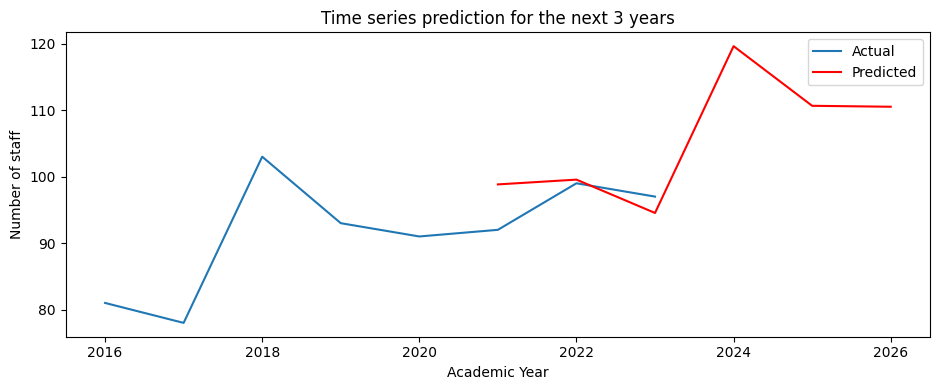

In [210]:
plot_time_series_model(merged_df["Total"], df_test, testing_error, forecasts, init_year)
# print(testing_error)